# Physics-Informed Neural Networks

Original [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125) by M.Raissi et al. 

In complex physical, biological or engineering systems, obtaining data is sometimes unachievable. State of the art machine learning techniques cannot provide any guarantee of convergence given the lack of training data. 

**Traditional physics model** creation is a task of a domain expert, who parametrises physics models to best fit a system of interest. For example, creating a model of aircraft dynamics using equations of drag, lift, gravity, thrust, etc., and parametrising the model to attempt to closely match the model to a specific aircraft.

However, sometimes physical systems are hard to parametrise and there does not exist a closed form solution. 

In [37]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 8})

import jax.numpy as jnp
from jax import value_and_grad, jit, random, vmap
import optax

from tqdm import tqdm

KEY = random.PRNGKey(1)

## The Solution to the Shrodinger Equation

As an example to illustrate how PINNs are applied, we will look at the solution to the non-linear Shrodinger equation.

The non-linear Shrodinger equation, along with its periodic boundary conditions is given by: $$i\frac{\partial h(x, t)}{\partial t} + 0.5 \frac{\partial^2 h(x, t)}{\partial x \partial x} + |h(x, t)|^2h(x, t) = 0$$ $$h(x, 0) = 2 sech(x)$$ $$h(-5, t) = h(5, t)$$ $$\frac{\partial h(-5, t)}{\partial x} = \frac{\partial h(5, t)}{\partial x}$$

The complex valued solution of the non-linear Schrodinger equaton is denoted as $$h(x, t), x\in[-5, 5], t \in [0, \pi/2]$$ The output of $h(x, t)$ will be $u + iv$, where $u$ is the real part and $v$ is the imaginary part. To better understand the solution and for easier visualization, we will inspect the norm of our solution $|h(x,t)| = \sqrt{u^2 + v^2}$ for the rest of the homework.

Below, we will import our dataset associated with the Shrodinger equation. The data include input values $x, t$ and it's corresponding output values $u, v$ pair. Please just run the following cells.

In [2]:
data = scipy.io.loadmat("original_paper/Data/NLS.mat")

# Global variables
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 50
N_b = 50
N_f = 20000

# Original data (including training and validation)
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['uu'])
v = np.imag(data['uu'])
h = np.sqrt(u**2 + v**2)

# Initial Condition Data (N = 50)
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
t0 = np.zeros(x0.shape)
u0 = u[idx_x,0:1]
v0 = v[idx_x,0:1]
X0 = np.concatenate([x0, t0], axis=1)
Y0 = np.concatenate([u0, v0], axis=1)

# Boundary Condition Data (N = 50 + 50)
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
t_ub = t_lb = tb
X_ub = np.concatenate([np.zeros(tb.shape) + ub[0], t_ub], axis=1)
X_lb = np.concatenate([np.zeros(tb.shape) + lb[0], t_lb], axis=1)
Xb = np.concatenate([X_ub, X_lb])
u_lb = u[0, idx_t][..., None]
u_ub = u_lb
v_lb = v[0, idx_t][..., None]
v_ub = v_lb
Y_ub = np.concatenate([u_ub, v_ub], axis=1)
Y_lb = np.concatenate([u_lb, v_lb], axis=1)
Yb = np.concatenate([Y_ub, Y_lb])

# Training data (N = 50 + (50 + 50))
X = np.concatenate([X0, Xb])
Y = np.concatenate([Y0, Yb])

In [3]:
print(f"Initial condition training data. X0: {X0.shape}, Y0: {Y0.shape}")
print(f"Boundary condition training data. Xb: {Xb.shape}, Yb: {Yb.shape}")
print(f"Total training data. X: {X.shape}, Y: {Y.shape}")

Initial condition training data. X0: (50, 2), Y0: (50, 2)
Boundary condition training data. Xb: (100, 2), Yb: (100, 2)
Total training data. X: (150, 2), Y: (150, 2)


Note that we only have 150 training data. In reality, with reasonable effort, we could only obtain the data at the initial and boundary conditions of the Shrodinger equation. The initial condition is when $t=0$, and the boundary condition is when $x=-5$ or $x=5$. 

In the paper, we are limited with 50 data points at the initial condition, 50 data points at the upper boundary condition, and 50 data points at the lower boundary condition. Combined, we have 150 data points to train our neural network. This is not desired, and we will see how vanilla MLP will perform in a low-data regime.


### Visualizing our full data

Before training our neural network, let us visualize how our full data look like. The full data include data that is not limited to our initial and boundary conditions. As mentioned above, we will visualize the complex valued solution through $|h(x, t)|$. 

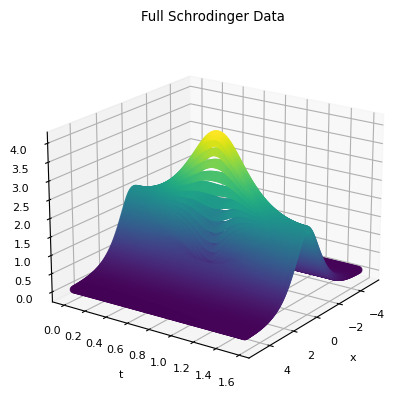

In [4]:
t_grid, x_grid = np.meshgrid(t,x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_grid, t_grid, h, c=h, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Full Schrodinger Data");

### Visualizing our training data on initial condition (t=0)

Now let us visualize the solution of our training data at the initial condition. We will visualize the real and imaginary part of our solution seperately

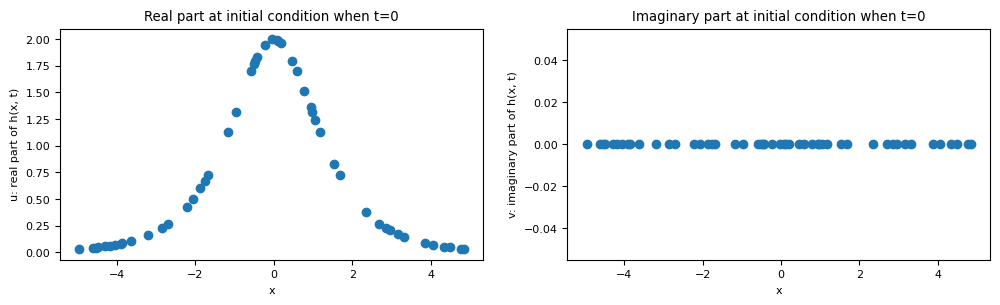

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(X0[:, 0], Y0[:, 0])
axs[1].scatter(X0[:, 0], Y0[:, 1])
axs[0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0");

### Visualizing our training data on boundary condition (x=-5 and x=5)

Now let us visualize the solution at the boundary conditions. Note that the solution for $h(-5, t)$ and $h(5, t)$ for all $t \in [0, \pi/2]$ is exactly the same.

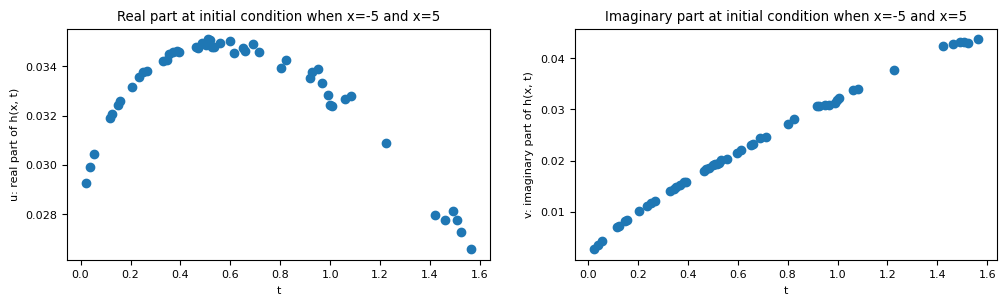

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(Xb[:50, 1], Yb[:50, 0])
axs[1].scatter(Xb[:50, 1], Yb[:50, 1])
axs[0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=-5 and x=5")
axs[1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=-5 and x=5");

## Vanilla MLP

Ok! We are ready to find the solution of the Shrodinger equation using traditional neural network architectures.

In traditional data-driven methods, we are trying to find the solution h(x,t) using a neural network and our training data described above. Here, according to the paper, the architecture is a traditional 5-layer MLP with $\tanh$ as activation functions. Specifically: $$NN(X) = W^{(5)}(\tanh(W^{(4)}\tanh(\dots) + b^{(4)})) + b^{(5)}$$ where $X = [x, t]$ is our input vector of shape (2), and $W^{(n)}, b^{(n)}$ indicate the weights and biases at each layer. 

According to the paper, the dimension for each layer is: $[2, 100, 100, 100, 100, 2]$. The output is of shape (2) in the form of $[u, v]$, the real and imaginary part of $h(x, t)$.

First implement `init_params` and `vanilla_forward`.

In [7]:
def init_params(layers, key=KEY):
    '''
    Initialize parameters in the MLP. Weights are initialized
    using Xavier initialization, while biases are zero initialized.

    Arguments
    - layers: A list indicating the dimension of each individual
      imbedding at layers of MLP. For example: [1, 10, 1] would
      indicate a simple 2 layer MLP. 

    Returns
    - params: the initialized parameters. For example, 
      [(w_1, b_1), (w_2, b_2)] is a valid output.
    '''
    def xavier_init(input_dim, output_dim, key=key):
        '''Use Xavier initialization for weights of a single layer'''
        w = None
        # ===== START OF YOUR CODE =====
        # compute standard deviation for xavier init
        # recall it is given by sqrt{2 /(?)}
        std_dev = jnp.sqrt(2/(input_dim + output_dim)) # TODO
        w = std_dev * random.normal(key, (input_dim, output_dim)) # TODO: initialize the weights
        # ===== END OF YOUR CODE =====
        return w

    params = []

    # ===== START OF YOUR CODE =====
    for l in range(len(layers) - 1): # TODO
        w = xavier_init(layers[l], layers[l+1]) # TODO: xavier initialize the weight
        b = jnp.zeros(layers[l+1]) # TODO: zero initialize the bias
        params.append((w, b)) # TODO: append weight and bias for this layer to params
    # ===== END OF YOUR CODE =====
    
    return params


def vanilla_forward(params, x):
    '''
    Forward pass through the vanilla MLP. In PINN, the nonlinearity are
    applied using tanh.

    Arguments
    - params: weights and biases for all layers of the vanilla MLP.
      For example, [(w_1, b_1), (w_2, b_2)] is a valid input.
    - x: input to the vanilla MLP

    Returns
    - out: output of the vanilla MLP
    '''
    activations = x

    # ===== START OF YOUR CODE =====
    # Create a for loop to loop over the parameters EXCEPT
    # the parameters corresponding to the very last layer.
    # This is because we will not be applying the nonlinearity
    # to the output of the last layer (which is out prediction).
    for w, b in params[:-1]: # TODO
        out = jnp.dot(activations, w) + b # TODO: Perform linear operation
        activations = jnp.tanh(out) # TODO: apply tanh activation
    
    final_w, final_b = params[-1] # TODO
    out = jnp.dot(activations, final_w) + final_b # TODO: Do not apply nonlinearity to last layer
    # ===== END OF YOUR CODE =====
    return out

# Use vmap to perform in parallel (jax magic)
vanilla_batched_forward = vmap(vanilla_forward, in_axes=(None, 0))

Test implementation for `init_param` and `vanilla_forward`.

In [8]:
layers = [2, 10, 1]
x = random.uniform(KEY, (5, 2))
out = vanilla_batched_forward(init_params(layers), x)
expected = jnp.array([[-0.05742961],
                      [-0.08960884],
                      [-0.04750253],
                      [-0.17843515],
                      [-0.09102767]])
assert jnp.allclose(out, expected)
print("Test passed!")

Test passed!


Now implement `vanilla_mseloss` and `step`.

In [46]:
def vanilla_mseloss(params, x, y):
    '''
    Compute mean squared error between x and y

    Arguments
    - layers: all params for the MLP
    - x: input to the MLP
    - y: true label
    '''
    loss = None
    # ===== START OF YOUR CODE =====
    pred = vanilla_batched_forward(params, x) # TODO: use `vanilla_batched_forward` to make prediction
    loss = jnp.mean(jnp.square(pred - y)) # TODO
    # ===== END OF YOUR CODE =====
    return loss

def vanilla_fit(params, optimizer, X, Y):
    '''
    Train your vanilla MLP using training data X and Y
    '''
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, y):
        '''
        Single step of our training algorithm.
        '''
        # ===== START OF YOUR CODE =====
        loss_value, grads = value_and_grad(vanilla_mseloss)(params, x, y) # TODO: check out `value_and_grad` using jax doc
        updates, opt_state = optimizer.update(grads, opt_state, params) # TODO: check out `optimizer.update()` using jax doc
        params = optax.apply_updates(params, updates) # TODO: check out `apply_updates()` using jax doc
        # ===== END OF YOUR CODE =====
        return params, opt_state, loss_value

    train_losses = []

    for epoch in tqdm(range(500)):
        for (x, y) in zip(X, Y):
            # ===== START OF YOUR CODE =====
            params, opt_state, loss_value = step(params, opt_state, x, y) # TODO
            # ===== END OF YOUR CODE =====
            train_losses.append(loss_value)
        # print(f'epoch {epoch}, average loss: {jnp.mean(loss_value)}')

    # plt.plot(train_losses)

    return params

In [47]:
layers = [2, 100, 100, 100, 100, 2]
optimizer = optax.adam(learning_rate=5e-4)

# ===== START OF YOUR CODE =====
trained_params = vanilla_fit(init_params(layers), optimizer, X, Y) # TODO
# ===== END OF YOUR CODE =====

100%|██████████| 500/500 [00:27<00:00, 18.40it/s]


### Visualize your training result

First visualize the performance on the training data. Note: It will look quite messy.

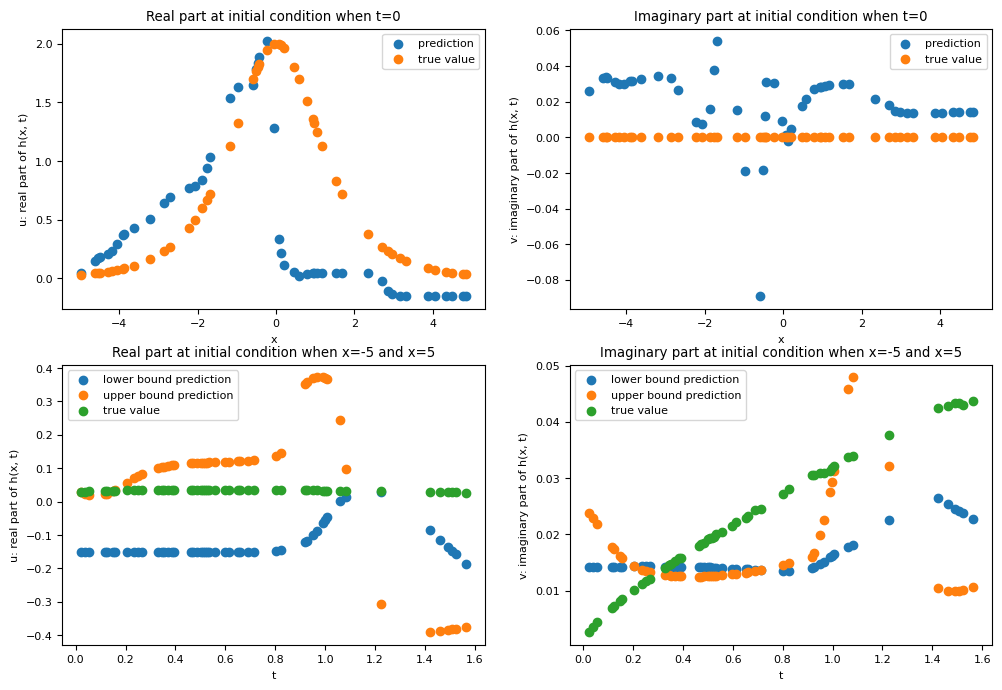

In [49]:
# ===== START OF YOUR CODE =====
pred = vanilla_batched_forward(trained_params, X) # TODO: make prediction using `trained_params`
# ===== END OF YOUR CODE =====

fig, axs = plt.subplots(2,2, figsize=(12, 8))
axs[0,0].scatter(X[:50, 0], pred[:50, 0], label="prediction")
axs[0,0].scatter(X[:50, 0], Y0[:, 0], label="true value")
axs[0,0].legend()
axs[0,1].scatter(X[:50, 0], pred[:50, 1], label="prediction")
axs[0,1].scatter(X[:50, 0], Y0[:, 1], label="true value")
axs[0,1].legend()
axs[0,0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[0,1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0")
axs[1,0].scatter(X[50:100, 1], pred[50:100, 0], label="lower bound prediction")
axs[1,0].scatter(X[100:, 1], pred[100:, 0], label="upper bound prediction")
axs[1,0].scatter(X[50:100, 1], Yb[0:50, 0], label="true value")
axs[1,0].legend()
axs[1,1].scatter(X[50:100, 1], pred[50:100, 1], label="lower bound prediction")
axs[1,1].scatter(X[100:, 1], pred[100:, 1], label="upper bound prediction")
axs[1,1].scatter(X[50:100, 1], Yb[0:50, 1], label="true value")
axs[1,1].legend()
axs[1,0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=-5 and x=5")
axs[1,1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=-5 and x=5");

Now visualize the performance on the full data. Note: It will look quite messy.

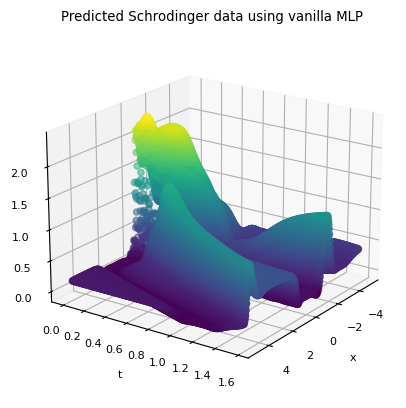

In [52]:
t_all = t_grid.flatten()[..., None]
x_all = x_grid.flatten()[..., None]
X_all = np.concatenate([x_all, t_all], axis=1)

pred = vanilla_batched_forward(trained_params, X_all)
pred_h = np.sqrt(pred[:,0]**2 + pred[:,1]**2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_all, t_all, pred_h, c=pred_h, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Predicted Schrodinger data using vanilla MLP");